In [1]:
import sys
from os.path import join as oj
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.append('../src')
import numpy as np
import data_pecarn, data_psrc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from validate import calc_stats
%matplotlib inline
%load_ext autoreload
%autoreload 2

d = data_psrc.get_data(use_processed=False, dummy=True) #use_processed_feats=True,)
iaii = d['iai_intervention']
iai = d['iai']
d['FAST (choice=not performed)'] = d['FAST (choice=0t performed)']
# print('fast options', [k for k in d.keys() if k.lower().startswith('fast')])
fast_study_cohort, fast_abnormal = data_psrc.get_FAST(d)    

# Performance of FAST exam in isolation

In [21]:
print(f'{d.shape[0]} total patients ({iaii.sum()} IAI-I, {iai.sum()} IAI)', )
print('\t FAST received', d[fast_study_cohort].shape[0], 'patients', iaii[fast_study_cohort].sum(), 'IAI-I', iai[fast_study_cohort].sum(), 'IAI')
print('\t FAST abnormal', d[fast_abnormal].shape[0], 'patients', iaii[fast_abnormal].sum(), 'IAI-I', iai[fast_abnormal].sum(), 'IAI')
print(f'Here\'s the breakdown of FAST patients:')
# print(f'\tOf these {fast_study_cohort.sum()} patients, {fast_abnormal.sum()} have an abnormal scan')
for k in ['FAST (choice=not performed)', 'FAST (choice=Negative)', 'FAST (choice=+ cardiac)', 'FAST (choice=+ right)', 'FAST (choice=+ left)', 'FAST (choice=+ pelvis)']:
    print('\t', k, d[k].sum(), 'patients', iaii[d[k].astype(bool)].sum(), 'IAI-I', iai[d[k].astype(bool)].sum(), 'IAI')

2188 total patients (62 IAI-I, 261 IAI)
	 FAST received 829 patients 27 IAI-I 97 IAI
	 FAST abnormal 65 patients 12 IAI-I 31 IAI
Here's the breakdown of FAST patients:
	 FAST (choice=not performed) 1359 patients 35 IAI-I 164 IAI
	 FAST (choice=Negative) 765 patients 15 IAI-I 66 IAI
	 FAST (choice=+ cardiac) 3 patients 0 IAI-I 0 IAI
	 FAST (choice=+ right) 20 patients 6 IAI-I 12 IAI
	 FAST (choice=+ left) 18 patients 4 IAI-I 11 IAI
	 FAST (choice=+ pelvis) 24 patients 4 IAI-I 11 IAI


In [15]:
print('If we use FAST alone to detect IAI-I, we get the following results:')
# print('assume no interpretation means negative')
tn, fp, fn, tp, sens, spec = calc_stats(iaii[fast_study_cohort],
                                  fast_abnormal[fast_study_cohort])
print(f'\tSensitivity={sens:0.2f}')
print(f'\tSpecificity={spec:0.2f}')
print(f'\t----------------')
print(f'\t{tp=} {fp=}')
print(f'\t{fn=} {tn=}')

If we use FAST alone to detect IAI-I, we get the following results:
	Sensitivity=0.44
	Specificity=0.93
	----------------
	tp=12 fp=53
	fn=15 tn=749


In [16]:
print('If we use FAST alone to detect IAI, we get the following results:')
# print('assume no interpretation means negative')
tn, fp, fn, tp, sens, spec = calc_stats(iai[fast_study_cohort],
                                  fast_abnormal[fast_study_cohort])
print(f'\tSensitivity={sens:0.2f}')
print(f'\tSpecificity={spec:0.2f}')
print(f'\t----------------')
print(f'\t{tp=} {fp=}')
print(f'\t{fn=} {tn=}')

If we use FAST alone to detect IAI, we get the following results:
	Sensitivity=0.32
	Specificity=0.95
	----------------
	tp=31 fp=34
	fn=66 tn=698


# FAST performance in conjunction with CDR rules
By itself, FAST has very low sensitivity so we might try combining it with rules from the PECARN CDR. However, we shouldn't use too many of the rules, as we will very quickly run out of data (especially considering we have very few abnormal FAST exams!)

In [18]:
rules = {
    'Abdominal wall trauma or seatbelt sign': d['AbdTrauma_or_SeatBeltSign_yes']==1,
    'GCSScore < 14': d['GCSScore'] < 14,
    'Abdominal tenderness': d['AbdTenderDegree_None'] == 0
}
print(f'We can try using any of the first three rules of the CDR + FAST to get a decent score. These are: {list(rules.keys())}')

We can try using any of the first three rules of the CDR + FAST to get a decent score. These are: ['Abdominal wall trauma or seatbelt sign', 'GCSScore < 14', 'Abdominal tenderness']


In [25]:
outcome = iaii
for k in rules.keys():
    print(f'If we use {k} + FAST to detect IAI-I, we get the following results:')
    # print('assume no interpretation means negative')
    tn, fp, fn, tp, sens, spec = calc_stats(outcome[fast_study_cohort],
                                      rules[k][fast_study_cohort] | fast_abnormal[fast_study_cohort])
    tn_k, fp_k, fn_k, tp_k, sens_k, spec_k = calc_stats(outcome[fast_study_cohort],  # without FAST
                                      rules[k][fast_study_cohort])
    print(f'\t\tSensitivity={sens:0.2f} (without FAST, {sens_k:0.2f})')
    print(f'\t\tSpecificity={spec:0.2f} (without FAST, {spec_k:0.2f})')
    print(f'\t\t----------------')
    print(f'\t\t{tp=} {fp=}')
    print(f'\t\t{fn=} {tn=}')

If we use Abdominal wall trauma or seatbelt sign + FAST to detect IAI-I, we get the following results:
		Sensitivity=0.78 (without FAST, 0.70)
		Specificity=0.73 (without FAST, 0.77)
		----------------
		tp=21 fp=215
		fn=6 tn=587
If we use GCSScore < 14 + FAST to detect IAI-I, we get the following results:
		Sensitivity=0.78 (without FAST, 0.52)
		Specificity=0.80 (without FAST, 0.85)
		----------------
		tp=21 fp=158
		fn=6 tn=644
If we use Abdominal tenderness + FAST to detect IAI-I, we get the following results:
		Sensitivity=0.93 (without FAST, 0.89)
		Specificity=0.68 (without FAST, 0.72)
		----------------
		tp=25 fp=253
		fn=2 tn=549


These specificities are too low. The same happens happens if we try FAST + all three of these rules:

In [26]:
print(f'If we use all three rules + FAST to detect IAI-I, we get the following results:')
# print('assume no interpretation means negative')
rule_pred = rules['Abdominal wall trauma or seatbelt sign'][fast_study_cohort] | rules['GCSScore < 14'][fast_study_cohort] | rules['Abdominal tenderness'][fast_study_cohort]
tn, fp, fn, tp, sens, spec = calc_stats(outcome[fast_study_cohort],
                                  rule_pred | fast_abnormal[fast_study_cohort])
tn_k, fp_k, fn_k, tp_k, sens_k, spec_k = calc_stats(outcome[fast_study_cohort],  # without FAST
                                  rule_pred)
print(f'\tSensitivity={sens:0.2f} (without FAST, {sens_k:0.2f})')
print(f'\tSpecificity={spec:0.2f} (without FAST, {spec_k:0.2f})')
print(f'\t----------------')
print(f'\t{tp=} {fp=}')
print(f'\t{fn=} {tn=}')
print(f'\t------without FAST----------')
print(f'\t{tp_k=} {fp_k=}')
print(f'\t{fn_k=} {tn_k=}')

If we use all three rules + FAST to detect IAI-I, we get the following results:
	Sensitivity=0.96 (without FAST, 0.96)
	Specificity=0.54 (without FAST, 0.56)
	----------------
	tp=26 fp=367
	fn=1 tn=435
	------without FAST----------
	tp_k=26 fp_k=350
	fn_k=1 tn_k=452


# Net benefit

**Net benefit calculation** - This is not all that meaningful. We have a lot of true negatives (tn), so the more we say that it is important, the more positive this metric will come out to be. The sensitivity/specificity and confusion matrices above are much clearer to interpret.

$\text { Net benefit }=\frac{\text { True positives }}{N}-\frac{\text { False positives }}{N} \times \frac{p_{t}}{1-p_{t}}$

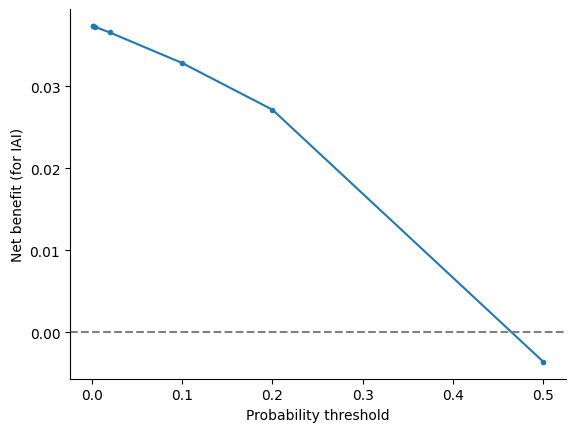

In [17]:
N = fast_study_cohort.sum()
ratios = [2, 5, 10, 50, 250, 500, 1000]
ps = []
nbs = []
for ratio in ratios:
    p = 1 / ratio
    net_benefit  = tp / N - fp / N * p / (1-p)
    nbs.append(net_benefit)
    ps.append(p)
plt.plot(ps, nbs, '.-')
plt.axhline(0, color='gray', ls='--')
plt.xlabel('Probability threshold')
plt.ylabel('Net benefit (for IAI)')
plt.show()